In [1]:
#import packages needed
import xarray as xr
import dask
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import os
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar

In [2]:
#load in T, subset space and time
def load_T(files_dir):
    T = xr.open_mfdataset(files_dir).thetao
    #subset spatially
    T = T.sel(lat=slice(-40,30),lon=slice(30,125))
    #subset time
    T = T.sel(time= slice('1950', '2015'))
    return T

In [2]:
import dask
import xarray
import pandas

In [4]:
@dask.delayed
def open_datefile_delayed(time, variable):
    return xarray.open_dataset(glob('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/THETAO/%(var)s_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_%(Y)04d%(M)02d*.nc'%
                                    {'var': variable, 'Y': time.year, 'M': time.month})[0],
                               chunks={'time':19})

def open_datefile(time, variable, var0):
    # Prepare to open the file
    var_data = open_datefile_delayed(time, variable)[variable].data
    
    # Get the size of the time axis - the number of 6 hour intervals between the beginning and end of the month
    time_axis = pandas.date_range(start = time - pandas.tseries.offsets.MonthBegin(),
                             end = time + pandas.tseries.offsets.MonthBegin(),
                             freq='M',
                             closed='left')
    
    # Tell Dask the delayed function returns an array, and the size and type of that array
    return dask.array.from_delayed(var_data, (time_axis.size, var0.lev.size, var0.lat.size, var0.lon.size), var0.dtype)

def open_erai(variable):
    files = sorted(glob('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/THETAO/%(var)s_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_*.nc'%
                 {'var': variable}))
    
    # First and last dataset
    ds0 = xarray.open_dataset(files[0])
    dsn = xarray.open_dataset(files[-1])
    
    # Full time axis
    time = pandas.date_range(ds0.time.values[0], dsn.time.values[-1], freq='M')
    
    # First file's variable (for horizontal/vertical coordinates)
    var0 = ds0[variable]
    
    # Time of each file in the series (one per month)
    months = pandas.date_range(ds0.time.values[0], dsn.time.values[-1], freq='1M')
    
    # Delayed opening of all the files using Dask
    dask_var = dask.array.concatenate([open_datefile(t, variable, var0) for t in months], axis=0)
    
    # Convert to xarray
    var = xarray.DataArray(dask_var,
                          name = var0.name,
                          attrs = var0.attrs,
                          dims = ['time', 'lev', 'lat', 'lon'],
                          coords = {
                              'time': time,
                              'lev': var0.lev,
                              'lat': var0.lat,
                              'lon': var0.lon,
                          })
    
    # Cleanup
    ds0.close()
    dsn.close()
    
    return var

In [5]:
z = open_erai('thetao')

In [6]:
files = sorted(glob('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/THETAO/%(var)s_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_*.nc'%
                 {'var': 'thetao'}))

In [7]:
z

,Array,Chunk
Bytes,2.56 GB,1.30 MB
Shape,"(1979, 5, 180, 360)","(1, 5, 180, 360)"
Count,9895 Tasks,1979 Chunks
Type,float32,numpy.ndarray


In [8]:
T = load_T('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/THETAO/thetao_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_*.nc')

In [9]:
T

<xarray.DataArray 'thetao' (time: 780, lev: 5, lat: 70, lon: 95)>
dask.array<getitem, shape=(780, 5, 70, 95), dtype=float32, chunksize=(120, 5, 70, 95), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float64 30.5 31.5 32.5 33.5 34.5 ... 121.5 122.5 123.5 124.5
  * lat      (lat) float64 -39.5 -38.5 -37.5 -36.5 -35.5 ... 26.5 27.5 28.5 29.5
  * lev      (lev) float64 5.0 15.0 25.0 35.0 45.0
Attributes:
    standard_name:  sea_water_potential_temperature
    long_name:      Sea Water Potential Temperature
    units:          degC
    comment:        Diagnostic should be contributed even for models using co...
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello volume: volcello
    history:        2019-11-08T18:41:01Z altered by CMOR: replaced missing va...

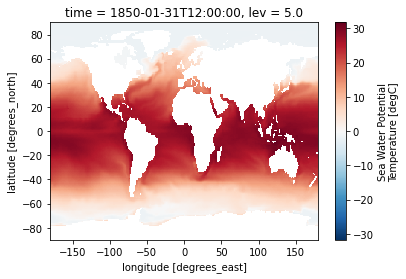

In [10]:
z[0,0].plot()

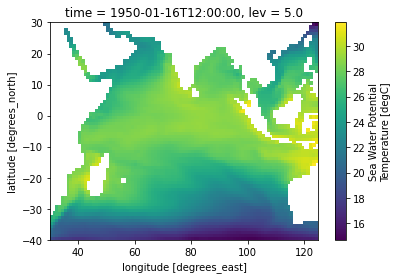

In [11]:
T[0,0].plot()

In [12]:
@dask.delayed
def open_datefile_delayed(time, variable):
    return xarray.open_dataset(glob('/scratch/e14/sm2435/CMIP6/%(mod)s/%(var)s/%(var)s_Omon_%(mod)s_historical_r1i1p1f1_gn_%(Y)04d%(M)02d*.nc'%
                                    {'var': variable, 'mod':model, 'Y': time.year, 'M': time.month})[0],
                               chunks={'time':1})

def open_datefile(time, variable, var0):
    # Prepare to open the file
    var_data = open_datefile_delayed(time, variable)[variable].data
    
    # Get the size of the time axis - the number of 6 hour intervals between the beginning and end of the month
    time_axis = pandas.date_range(start = time - pandas.tseries.offsets.MonthBegin(),
                             end = time + pandas.tseries.offsets.MonthBegin(),
                             freq='M',
                             closed='left')
    
    # Tell Dask the delayed function returns an array, and the size and type of that array
    return dask.array.from_delayed(var_data, (time_axis.size, var0.lev.size, var0.lat.size, var0.lon.size), var0.dtype)

def open_erai(model, variable):
    files = sorted(glob('/scratch/e14/sm2435/CMIP6/%(mod)s/%(var)s/%(var)s_Omon_%(mod)s_historical_r1i1p1f1_gn_*.nc'%
                 {'var': variable, 'mod':model}))
    
    # First and last dataset
    ds0 = xarray.open_dataset(files[0])
    dsn = xarray.open_dataset(files[-1])
    
    # Full time axis
    time = pandas.date_range(ds0.time.values[0], dsn.time.values[-1], freq='M')
    
    # First file's variable (for horizontal/vertical coordinates)
    var0 = ds0[variable]
    
    # Time of each file in the series (one per month)
    months = pandas.date_range(ds0.time.values[0], dsn.time.values[-1], freq='1M')
    
    # Delayed opening of all the files using Dask
    dask_var = dask.array.concatenate([open_datefile(t, variable, var0) for t in months], axis=0)
    
    # Convert to xarray
    var = xarray.DataArray(dask_var,
                          name = var0.name,
                          attrs = var0.attrs,
                          dims = ['time', 'lev', 'lat', 'lon'],
                          coords = {
                              'time': time,
                              'lev': var0.lev,
                              'lat': var0.lat,
                              'lon': var0.lon,
                          })
    
    # Cleanup
    ds0.close()
    dsn.close()
    
    return var

In [13]:
z = z.sel(lat=slice(-40,30),lon=slice(30,125))
    #subset time
z = z.sel(time= slice('1950', '2015'))

In [14]:
z

,Array,Chunk
Bytes,103.61 MB,133.00 kB
Shape,"(779, 5, 70, 95)","(1, 5, 70, 95)"
Count,12653 Tasks,779 Chunks
Type,float32,numpy.ndarray


In [15]:
z2 = z.chunk(19,41)

In [16]:
z2

,Array,Chunk
Bytes,103.61 MB,137.18 kB
Shape,"(779, 5, 70, 95)","(19, 5, 19, 19)"
Count,14334 Tasks,820 Chunks
Type,float32,numpy.ndarray


In [17]:
dTdt = z2.differentiate(coord = 'time',datetime_unit= 's')


In [18]:
test = dTdt.mean('lev').groupby('time.month').mean('time')

IndexError: list index out of range

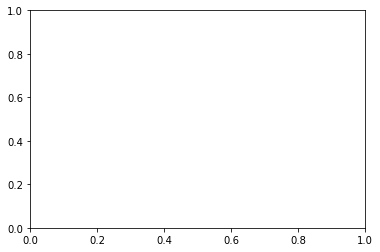

In [19]:
plt.pcolormesh(test[0])

In [44]:
import dask
from dask.diagnostics import ProgressBar

In [30]:
T = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/THETAO/*.nc', parallel=True).thetao


In [33]:
T1 = T.differentiate(coord = 'time',datetime_unit= 's')
T1 = T1.sel(lat=slice(-40,30),lon=slice(30,125))
#subset time
T1 = T1.sel(time= slice('1950', '2015'))

In [38]:
def get_weights(INP):
    weights = INP.lev
    #add a 0m surface layer
    wt=np.array([0.])
    for i in range(len(weights.values)):
        NW = 2*weights.values[i]-wt[i]
        wt = np.insert(wt,i+1,NW)
    thickness = wt[1:]-wt[:-1]
    thickness_DA = xr.DataArray(thickness, coords={'lev': INP.lev},
                 dims=['lev'])
    return thickness_DA

def weighted_avg(inp, weights):
    avg=inp.weighted(weights).mean('lev')
    return avg

In [39]:
weights = get_weights(T)
#now get wtd avg
dTdt = weighted_avg(T1, weights)

In [41]:
dTdt_c = dTdt.groupby('time.month').mean('time')

In [42]:
delayed = dTdt_c.to_netcdf('test_nc.nc', compute = False)


In [45]:
with ProgressBar():
    results = delayed.compute()

[########################################] | 100% Completed |  2.2s


/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [46]:
results

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


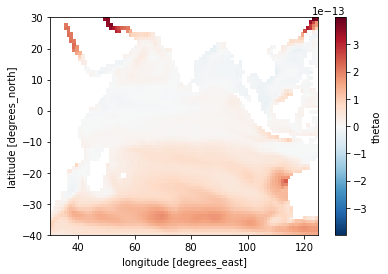

In [48]:
(dTdt_c[0]*dTdt_c[1]).plot()

In [52]:
T.lev

<xarray.DataArray 'lev' (lev: 5)>
array([ 5., 15., 25., 35., 45.])
Coordinates:
  * lev      (lev) float64 5.0 15.0 25.0 35.0 45.0
Attributes:
    standard_name:  depth
    long_name:      ocean depth coordinate
    units:          m
    positive:       down
    axis:           Z
    bounds:         lev_bnds

In [56]:
#load in ec-earth3 data and work out method for intepolating levels
Te = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/EC-Earth3/UO/*-20*.nc', parallel=True).uo


In [57]:
Te

<xarray.DataArray 'uo' (time: 180, lev: 20, lat: 180, lon: 360)>
dask.array<concatenate, shape=(180, 20, 180, 360), dtype=float32, chunksize=(12, 20, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) float64 0.5058 1.556 2.668 3.856 ... 41.18 47.21 53.85 61.11
Attributes:
    standard_name:  sea_water_x_velocity
    long_name:      Sea Water X Velocity
    units:          m s-1
    comment:        Prognostic x-ward velocity component resolved by the model.
    original_name:  uo
    cell_methods:   time: mean
    history:        2019-07-15T19:34:24Z altered by CMOR: Reordered dimension...

In [60]:
Te.lev


<xarray.DataArray 'lev' (lev: 20)>
array([ 0.50576 ,  1.555855,  2.667682,  3.85628 ,  5.140361,  6.543034,
        8.092519,  9.82275 , 11.77368 , 13.991038, 16.525322, 19.429802,
       22.757616, 26.5583  , 30.874561, 35.740204, 41.180023, 47.211895,
       53.850636, 61.112839])
Coordinates:
  * lev      (lev) float64 0.5058 1.556 2.668 3.856 ... 41.18 47.21 53.85 61.11
Attributes:
    standard_name:  depth
    long_name:      ocean depth coordinate
    units:          m
    positive:       down
    axis:           Z
    bounds:         lev_bnds

In [64]:
weights = Te.lev

In [65]:
wt=np.array([0.])
for i in range(len(weights.values)):
        NW = 2*weights.values[i]-wt[i]
        wt = np.insert(wt,i+1,NW)
thickness = wt[1:]-wt[:-1]

In [72]:
thickness

array([1.01152003, 1.08867049, 1.13498235, 1.24221396, 1.32594895,
       1.47939563, 1.61957479, 1.84088778, 2.0609715 , 2.37374568,
       2.6948216 , 3.11413836, 3.54148984, 4.05987811, 4.57264447,
       5.15864062, 5.72099805, 6.34274554, 6.93473554, 7.5896709 ])

In [71]:
weights

<xarray.DataArray 'lev' (lev: 20)>
array([ 0.50576 ,  1.555855,  2.667682,  3.85628 ,  5.140361,  6.543034,
        8.092519,  9.82275 , 11.77368 , 13.991038, 16.525322, 19.429802,
       22.757616, 26.5583  , 30.874561, 35.740204, 41.180023, 47.211895,
       53.850636, 61.112839])
Coordinates:
  * lev      (lev) float64 0.5058 1.556 2.668 3.856 ... 41.18 47.21 53.85 61.11
Attributes:
    standard_name:  depth
    long_name:      ocean depth coordinate
    units:          m
    positive:       down
    axis:           Z
    bounds:         lev_bnds

In [73]:
53.850636+7.5896709

61.4403069

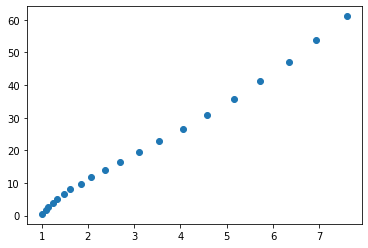

In [83]:
plt.scatter(thickness, weights)


In [106]:
min(wt[1:], key=lambda x:abs(x-50))

50.383267760276794

In [86]:
thickness

array([1.01152003, 1.08867049, 1.13498235, 1.24221396, 1.32594895,
       1.47939563, 1.61957479, 1.84088778, 2.0609715 , 2.37374568,
       2.6948216 , 3.11413836, 3.54148984, 4.05987811, 4.57264447,
       5.15864062, 5.72099805, 6.34274554, 6.93473554, 7.5896709 ])

In [88]:
(weights+thickness)

<xarray.DataArray 'lev' (lev: 20)>
array([ 1.51728004,  2.64452577,  3.80266404,  5.09849381,  6.46631026,
        8.02242923,  9.71209359, 11.66363788, 13.83465123, 16.364784  ,
       19.22014356, 22.54394031, 26.29910588, 30.61817813, 35.44720578,
       40.89884448, 46.90102124, 53.55464053, 60.78537107, 68.70250964])
Coordinates:
  * lev      (lev) float64 0.5058 1.556 2.668 3.856 ... 41.18 47.21 53.85 61.11

In [ ]:
wt=np.array([0.])
for i in range(len(weights.values)):
        NW = 2*weights.values[i]-wt[i]
        wt = np.insert(wt,i+1,NW)
depthz = wt[1:]-wt[:-1]

In [91]:
wt[1:]

array([ 1.01152003,  2.10019052,  3.23517287,  4.47738683,  5.80333579,
        7.28273141,  8.9023062 , 10.74319398, 12.80416548, 15.17791116,
       17.87273276, 20.98687112, 24.52836096, 28.58823907, 33.16088355,
       38.31952417, 44.04052222, 50.38326776, 57.3180033 , 64.90767419])

In [102]:
test = np.arange(5,50,10)

In [103]:
test

array([ 5, 15, 25, 35, 45])

In [104]:
wt2=np.array([0.])
for i in range(len(test)):
        NW2 = 2*test[i]-wt2[i]
        wt2 = np.insert(wt2,i+1,NW2)
depthz2 = wt2[1:]-wt2[:-1]

In [105]:
wt2

array([ 0., 10., 20., 30., 40., 50.])

In [107]:
def price(my_list,real_price):
    return max(price for price in my_list if price <= real_price)

In [112]:
u = price(wt[1:], 50)

In [113]:
u

44.04052221775055

In [240]:
#function to get T at 50m
def get_bot_layer(T):
    """
    Parameters
    --------------
    T : DataArray
        DataArray of chosen variable
    

    Returns
    --------------
    Array
        Array of the bottom of each layer (the k-1 coordinate from temperature)
    """
    T_lay = T.lev
    lay_bot=np.array([0.])
    for i in range(len(T_lay.values)):
        thickness = 2*T_lay.values[i]-lay_bot[i]
        lay_bot = np.insert(lay_bot,i+1,thickness)
    return lay_bot[1:]

def int_TUV_50(T):
    """
    Parameters
    --------------
    T : DataArray
        DataArray of chosen variable
    

    Returns
    --------------
    DataArray
        DataArray of the chosen variable for the k coordinate interpolated so \
        that bottom (vertical velocity) layer is at 50m
    """
    #get the bottom layer array
    bottom = get_bot_layer(T)
    #get the value of the layer under 50
    lev_n1 = max(val for val in bottom if val < 50)
    #now get the value of the layer to interpolate to
    lev_nt = lev_n1 + ((50-lev_n1)/2)
    return lev_nt

def insert_level(T):
    """
    Parameters
    --------------
    T : DataArray
        DataArray of chosen variable
    

    Returns
    --------------
    DataArray
        DataArray of the chosen variable with new interpolated value for T coordinate 
        corresopsonding to 50m (bottom (vertical velocity) layer is at 50m). 
        If this layer exists already, then nothing is inserted
    """
    #calc new level
    new_layer_val = int_TUV_50(T)
    #check if this level exists
    if new_layer_val not in T.lev.values:
        #interpolate values into new layer layer
        new_layer = T.interp(lev = new_layer_val)
        #now concat adding the last level, after removing any data deeper than desired layer
        T = T.sel(lev=slice(0,new_layer_val))
        Tnew = xr.concat([T, new_layer], dim = 'lev')
    else:
        #remove anyting below 50m
        Tnew = T.sel(lev=slice(0,50))
    return Tnew

def insert_level_w(T):
    """
    Parameters
    --------------
    T : DataArray
        DataArray of chosen variable
    

    Returns
    --------------
    DataArray
        DataArray of the chosen variable with new interpolated value for Z coordinate for W 
        corresopsonding to 50m (bottom (vertical velocity) layer is at 50m). 
        If this layer exists already, then nothing is inserted
    """
    #new level
    new_layer_val = 50
    #check if layer exists
    if new_layer_val not in T.lev.values:
        #interpolate values into new layer layer
        new_layer = T.interp(lev = new_layer_val)
        #now concat adding the last level, after removing any data that comes before hand
        T = T.sel(lev=slice(0,new_layer_val))
        Tnew = xr.concat([T, new_layer], dim = 'lev')
    else:
        #remove all bellow 50m
        Tnew = T.sel(lev=slice(0,51))
    return Tnew

In [241]:
def diff_T(T):
    dTdt = T.differentiate(coord = 'time', edge_order=1,  datetime_unit= 's')
    return dTdt


In [242]:
def get_weights(INP):
    weights = INP.lev
    #add a 0m surface layer
    wt=np.array([0.])
    for i in range(len(weights.values)):
        NW = 2*weights.values[i]-wt[i]
        wt = np.insert(wt,i+1,NW)
    thickness = wt[1:]-wt[:-1]
    thickness_DA = xr.DataArray(thickness, coords={'lev': INP.lev},
                 dims=['lev'])
    return thickness_DA

def weighted_avg(inp):
    weights = get_weights(inp)
    avg=inp.weighted(weights).mean('lev')
    return avg


def get_clim(INP):
    INP = INP.groupby('time.month').mean('time')
    return INP

In [ ]:
def fill ridge_line():
    
     if math.isnan(var.sel(lat=slice(-69,11),lon=slice(72,74)).mean()) is True:
        blank=sst.where(sst>0, drop=True)#get rid of blanks section
        line = sst.interpolate_na('lon').sel(lat=slice(-69,11),lon=slice(72,74))#get line of blank data
        rolled=blank.assign_coords(lon=(blank.lon % 360)).roll(lon=106, roll_coords=True)#move the blank space to end
        alvals=xr.concat([line, rolled], dim = 'lon')#concat data
        sst=alvals.assign_coords(lon=(alvals.lon % 360)).roll(lon=-108, roll_coords=True)#back to original format
    if DS in glob.glob('../../../CMIP_TOS/CMCC*.nc'):
        blank=sst.where(sst>0, drop=True)#get rid of blanks section
        line = sst.interpolate_na('lon').sel(lat=slice(-69,11),lon=slice(78,80))#get line of blank data
        rolled=blank.assign_coords(lon=(blank.lon % 360)).roll(lon=100, roll_coords=True)#move the blank space to end
        alvals=xr.concat([line, rolled], dim = 'lon')#concat data
        sst=alvals.assign_coords(lon=(alvals.lon % 360)).roll(lon=-102, roll_coords=True)

In [243]:
def get_temp_tendency(model):
    #load in T
    T = xr.open_mfdataset(model, parallel=True).thetao
    #subset spatially
    T = T.sel(lat=slice(-40,30),lon=slice(30,125))
    #subset time
    T = T.sel(time= slice('1950', '2015'))
    #interpolate to 50m
    T = insert_level(T)
    #get time deriviative
    dTdt = diff_T(T)
    #weighted average
    dTdt_w = weighted_avg(dTdt)
    #get climatology
    dTdt_clim = get_clim(dTdt_w)
    return dTdt_clim

In [254]:
#fucntions to get dtdx and dtdy
def T_xgrad(T):
    dTdx = T.differentiate('lon', edge_order = 1) / (110e3 * np.cos(T.lat * np.pi / 180))
    return dTdx
def T_ygrad(T):
    dTdy = T.differentiate('lat'. edge_order = 1) / (110e3 )
    return dTdy
def load_U(model):
    #load in U
    U = xr.open_mfdataset(model, parallel=True).uo
    #subset spatially
    U = U.sel(lat=slice(-40,30),lon=slice(30,125))
    #subset time
    U = U.sel(time= slice('1950', '2015'))
    #interpolate to 50m
    U = insert_level(U)
    #set land values to 0
    U = U.fillna(0)
    return U
def load_V(model):
    #load in U
    U = xr.open_mfdataset(model, parallel=True).vo
    #subset spatially
    U = U.sel(lat=slice(-40,30),lon=slice(30,125))
    #subset time
    U = U.sel(time= slice('1950', '2015'))
    #interpolate to 50m
    U = insert_level(U)
    #set land values to 0
    U = U.fillna(0)
    return U
def load_T(model):
    #load in U
    T = xr.open_mfdataset(model, parallel=True).thetao
    #subset spatially
    T = T.sel(lat=slice(-40,30),lon=slice(30,125))
    #subset time
    T = T.sel(time= slice('1950', '2015'))
    #interpolate to 50m
    T = insert_level(T)
    return T

def get_uadv(modelu, modelt):
    #load u
    U = load_U(modelu)
    T = load_T(modelt)
    #get xgrad
    dtdx = T_xgrad(T)
    #calc advection
    uadv = U*dtdx
    #weighted average
    uadv_w = weighted_avg(uadv)
    #get climatology
    uadv_clim = get_clim(uadv_w)
    return uadv_clim

def get_vadv(modelv, modelt):
    #load u
    V = load_V(modelv)
    T = load_T(modelt)
    #get xgrad
    dtdy = T_ygrad(T)
    #calc advection
    vadv = v*dtdy
    #weighted average
    vadv_w = weighted_avg(vadv)
    #get climatology
    vadv_clim = get_clim(vadv_w)
    return vadv_clim

In [289]:
#make functions for getting w advection
def load_U_w(model):
    #load in U
    U = xr.open_mfdataset(model, parallel=True).uo
    #subset spatially
    U = U.sel(lat=slice(-40,30),lon=slice(30,125))
    #subset time
    U = U.sel(time= slice('1950', '2015'))
    #set land values to 0
    U = U.fillna(0)
    return U
def load_V_w(model):
    #load in U
    U = xr.open_mfdataset(model, parallel=True).vo
    #subset spatially
    U = U.sel(lat=slice(-40,30),lon=slice(30,125))
    #subset time
    U = U.sel(time= slice('1950', '2015'))
    #set land values to 0
    U = U.fillna(0)
    return U
def calc_w(model_u, model_v):
    U = load_U_w(model_u)
    V = load_V_w(model_v)
    dudx = U.differentiate(coord = 'lon') / (110e3 * np.cos(U.lat * np.pi / 180))
    dvdy = V.differentiate(coord='lat') / (110e3)
    lay_bot = get_bot_layer(U)
    w_list = []
    for i, j in enumerate(lay_bot):
        if i == 0:
            w = (dudx[:,i]*j + dvdy[:,i]*j)
            #add to new DataArray with vertical coords put in
            w = w.assign_coords({'lev': lay_bot[i]})
            w_list.append(w)
        else:
            l = (dudx[:,i]*j + dvdy[:,i]*j) + w_list[i-1]
            w = l.assign_coords({'lev': lay_bot[i]})
            w_list.append(w)
    #now put all layers into one array
    w = xr.concat(w_list, dim = 'lev')
    return w
def T_zgrad(T):
    #get z at 50m layer (but at t coordinate part of it)
    dTdz = (T[:,0] - T[:,-1])/float(T.lev[-1])
    return dTdz

def get_wadv(modelu, modelv, modelt):
    #load 
    W = calc_w(modelu, modelv)
    #get W at 50 m
    W = W.interp(lev=50)
    T = load_T(modelt)
    #get zgrad
    dtdz = T_zgrad(T)
    #calc advection
    wadv = W*dtdz
    wadv_clim = get_clim(wadv)
    return wadv_clim
        

In [ ]:
#now lets make a fucntion to go through the net heat flux data,
#and a generic fucntion to get a varibles climaotology with no operations done
def load_hfds(model):
    q = xr.open_mfdataset(model, parallel=True).hfds
    #subset spatially
    q = q.sel(lat=slice(-40,30),lon=slice(30,125))
    #subset time
    q = q.sel(time= slice('1950', '2015'))
    return q

def load_rsntds(model):
    r = xr.open_mfdataset(model, parallel=True).rsntds
    #subset spatially
    r = r.sel(lat=slice(-40,30),lon=slice(30,125))
    #subset time
    r = r.sel(time= slice('1950', '2015'))
    return q

def get_qnet(q_data, sw_data):
    Q = load_hfds(q_data)
    SW = load_rsntds(sw_data)
    SW_component = SW*((0.67*np.exp(-50))+((1-0.67)*np.exp(-50/17)))
    qnet = ((Q-SW_component)/(3986*1026*50))
    #now get climatology
    qnet = get_clim(qnet)
    return qnet

In [287]:
w = calc_w('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/UO/*.nc', '/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/VO/*.nc')

In [290]:
wadv = get_wadv('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/UO/*.nc', '/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/VO/*.nc', '/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/THETAO/*.nc')

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


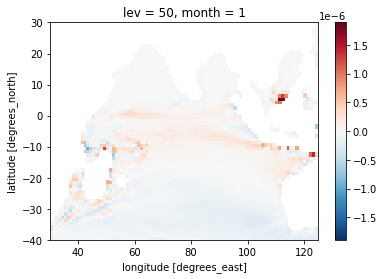

In [292]:
wadv[0].plot()

In [256]:
uadvection = get_uadv('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/UO/*.nc', '/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/THETAO_deeper/thetao_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_*.nc')

In [257]:
uadvection.to_netcdf('uadv_test.nc')

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


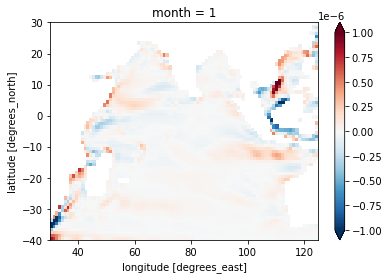

In [261]:
(-1*uadvection)[0].plot(vmin = -1e-6, vmax = 1e-6, cmap = 'RdBu_r')

In [244]:
dtclim = get_temp_tendency('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/THETAO_deeper/thetao_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_*.nc')

In [245]:
dtclim

<xarray.DataArray 'thetao' (month: 12, lat: 70, lon: 95)>
dask.array<stack, shape=(12, 70, 95), dtype=float64, chunksize=(1, 70, 95), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 30.5 31.5 32.5 33.5 34.5 ... 121.5 122.5 123.5 124.5
  * lat      (lat) float64 -39.5 -38.5 -37.5 -36.5 -35.5 ... 26.5 27.5 28.5 29.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [246]:
dtclim.to_netcdf('testnc.nc')

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [247]:
dtclim.load()

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'thetao' (month: 12, lat: 70, lon: 95)>
array([[[ 2.49300744e-07,  2.40774166e-07,  2.36564945e-07, ...,
          5.51796429e-07,  5.51116783e-07,  5.50316742e-07],
        [ 3.11692229e-07,  2.95001711e-07,  2.83465269e-07, ...,
          5.78312575e-07,  5.71887915e-07,  5.67426091e-07],
        [ 3.61016930e-07,  3.37434700e-07,  3.25075920e-07, ...,
          5.81045280e-07,  5.71354990e-07,  5.65745264e-07],
        ...,
        [            nan,             nan,             nan, ...,
         -6.29188891e-07, -5.23318494e-07, -5.07235885e-07],
        [            nan,             nan,             nan, ...,
         -7.63379846e-07, -6.46854682e-07, -4.64758995e-07],
        [            nan,             nan,             nan, ...,
                     nan, -8.11595824e-07, -8.09139350e-07]],

       [[ 1.95078293e-07,  1.84920829e-07,  1.75775531e-07, ...,
          2.70423947e-07,  2.72716552e-07,  2.75730965e-07],
        [ 2.16318979e-07,  2.04740909e-07,  1.94339237e-07, ...,
          2.94694180e-07,  2.91760534e-07,  2.91688425e-07],
        [ 2.27418524e-07,  2.04912875e-07,  1.91926772e-07, ...,
          2.94050235e-07,  2.89591893e-07,  2.92209549e-07],
...
        [            nan,             nan,             nan, ...,
         -6.09658181e-07, -5.22642357e-07, -4.73420313e-07],
        [            nan,             nan,             nan, ...,
         -7.55338261e-07, -6.85630604e-07, -5.78294373e-07],
        [            nan,             nan,             nan, ...,
                     nan, -8.18548515e-07, -8.41851727e-07]],

       [[ 2.43056872e-07,  2.39284683e-07,  2.40292067e-07, ...,
          6.30271913e-07,  6.26993530e-07,  6.24239251e-07],
        [ 3.23623715e-07,  3.14317776e-07,  3.07063589e-07, ...,
          6.53300851e-07,  6.47075848e-07,  6.39563996e-07],
        [ 3.78744551e-07,  3.69505729e-07,  3.62888284e-07, ...,
          6.65865285e-07,  6.56364591e-07,  6.40600174e-07],
        ...,
        [            nan,             nan,             nan, ...,
         -6.87428309e-07, -5.79413245e-07, -5.47455675e-07],
        [            nan,             nan,             nan, ...,
         -8.86907480e-07, -7.69531555e-07, -5.23072036e-07],
        [            nan,             nan,             nan, ...,
                     nan, -9.45204385e-07, -9.31316156e-07]]])
Coordinates:
  * lon      (lon) float64 30.5 31.5 32.5 33.5 34.5 ... 121.5 122.5 123.5 124.5
  * lat      (lat) float64 -39.5 -38.5 -37.5 -36.5 -35.5 ... 26.5 27.5 28.5 29.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

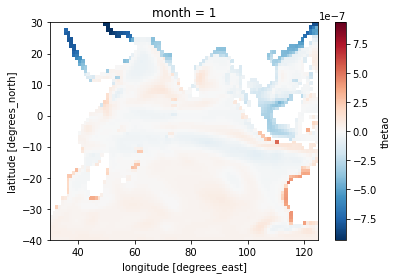

In [239]:
dtclim[0].plot()

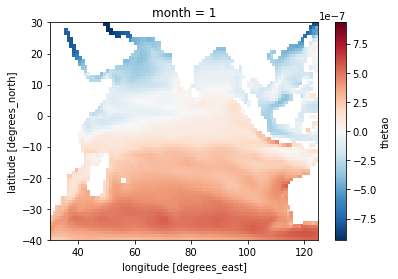

In [248]:
dtclim[0].plot()

In [1]:
import os

In [3]:
os.listdir('/home/z5113258/Documents/')

['test.nc',
 'Welcomedoc2020.pdf',
 'data',
 'Mendeley_Desktop',
 'GODAS',
 'EC-Earth3_TOS',
 'SODA3.4.2',
 'Scripts',
 'test1.nc',
 'ORAS5',
 'honours_paper_anal',
 'figures']

In [ ]:
os.path.join()